##### Copyright 2020 The TensorFlow Authors.
##### Copyright 2020 Imperial College London.

Licensed under the MIT License.

In [0]:
#@title Licensed under the MIT License { display-mode: "form" }

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

# Modeling COVID-19 spread in Europe and the effect of interventions

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Estimating_COVID_19_in_11_European_countries.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Estimating_COVID_19_in_11_European_countries.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

To slow the spread of COVID-19 in early 2020, European countries adopted non-pharmaceutical interventions such as closure of non-essential businesses, isolation of individual cases, travel bans, and other measures to encourage social distancing. The Imperial College COVID-19 Response Team analyzed the effectiveness of these measures in their paper ["Estimating the number of infections and the impact of non-pharmaceutical interventions on COVID-19 in 11 European countries"](https://doi.org/10.25561/77731), using a Bayesian hierarchical model combined with a mechanistic epidemiological model.

This Colab contains a TensorFlow Probability (TFP) implementation of that analysis, organized as follows:
- "Model setup" defines the epidemiological model for disease transmission and resulting deaths, the Bayesian prior distribution over model parameters, and the distribution of number of deaths conditional on parameter values.
- "Data preprocessing" loads in data on the timing and type of interventions in each country, counts of deaths over time, and estimated fatality rates for those infected.
- "Model inference" builds a Bayesian hierarchical model and runs Hamiltonian Monte Carlo (HMC) to sample from the posterior distribution over parameters.
- "Results" shows posterior predictive distributions for quantities of interest such as forecasted deaths, and counterfactual deaths in the absence of interventions.

The paper found evidence that countries had managed to reduce the number of new infections transmitted by each infected person ($R_t$), but that credible intervals contained $R_t=1$ (the value above which the epidemic continues to spread) and that it was premature to draw strong conclusions on the effectiveness of interventions. The Stan code for the paper is in the authors' [Github](https://github.com/ImperialCollegeLondon/covid19model) repository, and this Colab reproduces [Version 2](https://github.com/ImperialCollegeLondon/covid19model/commit/25ef22e68fbbbd2fcbdf8ea2bde8e26a8a440bf6#diff-445347d4d98a197511cb1c4e17e55c33).



In [0]:
!pip3 install -q git+git://github.com/arviz-devs/arviz.git
!pip3 install -q tf-nightly tfp-nightly

In [0]:
#@title Imports
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
from pprint import pprint

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
from tensorflow_probability.python.internal import prefer_static as ps

tf.enable_v2_behavior()

# Globally Enable XLA.
# tf.config.optimizer.set_jit(True)

try:
  physical_devices = tf.config.list_physical_devices('GPU')
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

tfb = tfp.bijectors
tfd = tfp.distributions

DTYPE = np.float32

## 1  Model setup

### 1.1  Mechanistic model for infections and deaths
The infection model simulates the number of infections in each country over time. Input data are the timing and type of interventions, population size, and initial cases. Parameters control the effectiveness of interventions and the rate of disease transmission. The model for the expected number of deaths applies a fatality rate to the predicted infections.

The infection model performs a convolution of previous daily infections with the serial interval distributution (the distribution over the number of days between becoming infected and infecting someone else). At each time step, the number of new infections at time $t$, $n_t$, is calculated as

\begin{equation}
\sum_{i=0}^{t-1} n_i \mu_t 	ext{p} (\text{caught from someone infected at } i | \text{newly infected at } t)
\end{equation}
where $\mu_t=R_t$ and the conditional probability is stored in `conv_serial_interval`, defined below.

The model for expected deaths performs a convolution of daily infections and the distribution of days between infection and death. That is, expected deaths on day $t$ is calculated as

\begin{equation}
\sum_{i=0}^{t-1} n_i\text{p(death on day $t$|infection on day $i$)}
\end{equation}
where the conditional probability is stored in `conv_fatality_rate`, defined below.

In [0]:
from tensorflow_probability.python.mcmc.internal import util as mcmc_util

def predict_infections(
    intervention_indicators, population, initial_cases, mu, alpha_hier,
    conv_serial_interval, initial_days, total_days):
  """Predict the number of infections by forward-simulation.

  Args:
    intervention_indicators: Binary array of shape
      `[num_countries, total_days, num_interventions]`, in which `1` indicates
      the intervention is active in that country at that time and `0` indicates
      otherwise.
    population: Vector of length `num_countries`. Population of each country.
    initial_cases: Array of shape `[batch_size, num_countries]`. Number of cases
      in each country at the start of the simulation.
    mu: Array of shape `[batch_size, num_countries]`. Initial reproduction rate
      (R_0) by country.
    alpha_hier: Array of shape `[batch_size, num_interventions]` representing
      the effectiveness of interventions.
    conv_serial_interval: Array of shape
      `[total_days - initial_days, total_days]` output from
      `make_conv_serial_interval`. Convolution kernel for serial interval
      distribution.
    initial_days: Integer, number of sequential days to seed infections after
      the 10th death in a country. (N0 in the authors' Stan code.)
    total_days: Integer, number of days of observed data plus days to forecast.
      (N2 in the authors' Stan code.)
  Returns:
    predicted_infections: Array of shape
      `[total_days, batch_size, num_countries]`. (Batched) predicted number of
      infections over time and by country.
  """
  alpha = alpha_hier - tf.cast(np.log(1.05) / 6.0, DTYPE)

  # Multiply the effectiveness of each intervention in each country (alpha)
  # by the indicator variable for whether the intervention was active and sum
  # over interventions, yielding an array of shape
  # [total_days, batch_size, num_countries] that represents the total effectiveness of
  # all interventions in each country on each day (for a batch of data).
  linear_prediction = tf.einsum(
      'ijk,...k->j...i', intervention_indicators, alpha)

  # Adjust the reproduction rate per country downward, according to the
  # effectiveness of the interventions.
  rt = mu * tf.exp(-linear_prediction, name='reproduction_rate')

  # Initialize storage array for daily infections and seed it with initial
  # cases.
  daily_infections = tf.TensorArray(
      dtype=DTYPE, size=total_days, element_shape=initial_cases.shape)
  for i in range(initial_days):
    daily_infections = daily_infections.write(i, initial_cases)

  # Initialize cumulative cases.
  init_cumulative_infections = initial_cases * initial_days

  # Simulate forward for total_days days.
  cond = lambda i, *_: i < total_days
  def body(i, prev_daily_infections, prev_cumulative_infections):
    # The probability distribution over days j that someone infected on day i
    # caught the virus from someone infected on day j.
    p_infected_on_day = tf.gather(
        conv_serial_interval, i - initial_days, axis=0)

    # Multiply p_infected_on_day by the number previous infections each day and
    # by mu, and sum to obtain new infections on day i. Mu is adjusted by
    # the fraction of the population already infected, so that the population
    # size is the upper limit on the number of infections.
    prev_daily_infections_array = prev_daily_infections.stack()
    to_sum = prev_daily_infections_array * mcmc_util.left_justified_expand_dims_like(
        p_infected_on_day, prev_daily_infections_array)
    convolution = tf.reduce_sum(to_sum, axis=0)
    rt_adj = (
        (population - prev_cumulative_infections) / population
        ) * tf.gather(rt, i)
    new_infections = rt_adj * convolution

    # Update the prediction array and the cumulative number of infections.
    daily_infections = prev_daily_infections.write(i, new_infections)
    cumulative_infections = prev_cumulative_infections + new_infections
    return i + 1, daily_infections, cumulative_infections

  _, daily_infections_final, last_cumm_sum = tf.while_loop(
      cond, body,
      (initial_days, daily_infections, init_cumulative_infections),
      maximum_iterations=(total_days - initial_days))
  return daily_infections_final.stack()

def predict_deaths(predicted_infections, ifr_noise, conv_fatality_rate):
  """Expected number of reported deaths by country, by day.

  Args:
    predicted_infections: Array of shape
      `[total_days, batch_size, num_countries]` output from
      `predict_infections`.
    ifr_noise: Array of shape `[batch_size, num_countries]`. Noise in Infection
      Fatality Rate (IFR).
    conv_fatality_rate: Array of shape
      `[total_days - 1, total_days, num_countries]`. Convolutional kernel for
      calculating fatalities, output from `make_conv_fatality_rate`.
  Returns:
    predicted_deaths: Array of shape `[total_days, batch_size, num_countries]`.
      (Batched) predicted number of deaths over time and by country.
  """
  # Multiply the number of infections on day j by the probability of death
  # on day i given infection on day j, and sum over j. This yields the expected
  result_remainder = tf.einsum(
      'i...j,kij->k...j', predicted_infections, conv_fatality_rate) * ifr_noise

  # Concatenate the result with a vector of zeros so that the first day is
  # included.
  result_temp = 1e-15 * predicted_infections[:1]
  return tf.concat([result_temp, result_remainder], axis=0)

### 1.2  Prior over parameter values

Here we define the joint prior distribution over the model parameters. Many of the parameter values are assumed to be independent, such that the prior can be expressed as:

$\text p(\tau, y, \psi, \kappa, \mu, \alpha) = \text p(\tau)\text p(y|\tau)\text p(\psi)\text p(\kappa)\text p(\mu|\kappa)\text p(\alpha)\text p(\epsilon)$

in which:

- $\tau$ is the shared rate parameter of the Exponential distribution over the number of initial cases per country, $y = y_1, ... y_{num\_countries}$.
- $\psi$ is a parameter in the Negative Binomial distribution for number of deaths.
- $\kappa$ is the shared scale parameter of the HalfNormal distribution over the initial reproduction number in each country, $\mu = \mu_1, ..., \mu_{num\_countries}$ (indicating the number of additional cases transmitted by each infected person).
- $\alpha = \alpha_1, ..., \alpha_6$ is the effectiveness of each of the six interventions.
- $\epsilon$ (called `ifr_noise` in the code, after the authors' Stan code) is noise in the Infection Fatality Rate (IFR).

We express this model as a TFP JointDistribution, a type of TFP distribution that enables expression of probabilistic graphical models.

In [0]:
def make_jd_prior(num_countries, num_interventions):
  return tfd.JointDistributionSequentialAutoBatched([
      # Rate parameter for the distribution of initial cases (tau).
      tfd.Exponential(rate=tf.cast(0.03, DTYPE)),

      # Initial cases for each country.
      lambda tau: tfd.Sample(
          tfd.Exponential(rate=tf.cast(1, DTYPE) / tau),
          sample_shape=num_countries),

      # Parameter in Negative Binomial model for deaths (psi).
      tfd.HalfNormal(scale=tf.cast(5, DTYPE)),

      # Parameter in the distribution over the initial reproduction number, R_0
      # (kappa).
      tfd.HalfNormal(scale=tf.cast(0.5, DTYPE)),

      # Initial reproduction number, R_0, for each country (mu).
      lambda kappa: tfd.Sample(
          tfd.TruncatedNormal(loc=3.28, scale=kappa, low=1e-5, high=1e5),
          sample_shape=num_countries),

      # Impact of interventions (alpha; shared for all countries).
      tfd.Sample(
          tfd.Gamma(tf.cast(0.1667, DTYPE), 1), sample_shape=num_interventions),

      # Multiplicative noise in Infection Fatality Rate.
      tfd.Sample(
          tfd.TruncatedNormal(
              loc=tf.cast(1., DTYPE), scale=0.1, low=1e-5, high=1e5),
              sample_shape=num_countries)
  ])


### 1.3  Likelihood of observed deaths conditional on parameter values

The likelihood model expresses $p(\text{deaths} | \tau, y, \psi, \kappa, \mu, \alpha, \epsilon)$. It applies the models for the number of infections and expected deaths conditional on parameters, and assumes actual deaths follow a Negative Binomial distribution.



In [0]:
def make_likelihood_fn(
    intervention_indicators, population, deaths,
    infection_fatality_rate, initial_days, total_days):

  # Create a mask for the initial days of simulated data, as they are not
  # counted in the likelihood.
  observed_deaths = tf.constant(deaths.T[np.newaxis, ...], dtype=DTYPE)
  mask_temp = deaths != -1
  mask_temp[:, :START_DAYS] = False
  observed_deaths_mask = tf.constant(mask_temp.T[np.newaxis, ...])

  conv_serial_interval = make_conv_serial_interval(initial_days, total_days)
  conv_fatality_rate = make_conv_fatality_rate(
      infection_fatality_rate, total_days)

  def likelihood_fn(tau, initial_cases, psi, kappa, mu, alpha_hier, ifr_noise):
    # Run models for infections and expected deaths
    predicted_infections = predict_infections(
        intervention_indicators, population, initial_cases, mu, alpha_hier,
        conv_serial_interval, initial_days, total_days)
    e_deaths_all_countries = predict_deaths(
        predicted_infections, ifr_noise, conv_fatality_rate)

    # Construct the Negative Binomial distribution for deaths by country.
    mu_m = tf.transpose(e_deaths_all_countries, [1, 0, 2])
    psi_m = psi[..., tf.newaxis, tf.newaxis]
    probs = tf.clip_by_value(mu_m / (mu_m + psi_m), 1e-9, 1.)
    likelihood_elementwise = tfd.NegativeBinomial(
        total_count=psi_m, probs=probs).log_prob(observed_deaths)
    return tf.reduce_sum(
        tf.where(observed_deaths_mask,
                likelihood_elementwise,
                tf.zeros_like(likelihood_elementwise)),
        axis=[-2, -1])

  return likelihood_fn


### 1.4  Probability of death given infection

This section computes the distribution of deaths on the days following infection. It assumes the time from infection to death is the sum of two Gamma-variate quantities, representing the time from infection to disease onset and the time from onset to death. The time-to-death distribution is combined with Infection Fatality Rate data from [Verity et al. (2020)](https://www.medrxiv.org/content/10.1101/2020.03.09.20033357v1) to compute the probability of death on days following infection.

In [0]:
def daily_fatality_probability(infection_fatality_rate, total_days):
  """Computes the probability of death `d` days after infection."""

  # Convert from alternative Gamma parametrization and construct distributions
  # for number of days from infection to onset and onset to death.
  concentration1 = tf.cast((1. / 0.86)**2, DTYPE)
  rate1 = concentration1 / 5.1
  concentration2 = tf.cast((1. / 0.45)**2, DTYPE)
  rate2 = concentration2 / 18.8
  infection_to_onset = tfd.Gamma(concentration=concentration1, rate=rate1)
  onset_to_death = tfd.Gamma(concentration=concentration2, rate=rate2)

  # Create empirical distribution for number of days from infection to death.
  inf_to_death_dist = tfd.Empirical(
      infection_to_onset.sample([5e6]) + onset_to_death.sample([5e6]))

  # Subtract the CDF value at day i from the value at day i + 1 to compute the
  # probability of death on day i given infection on day 0, and given that
  # death (not recovery) is the outcome.
  times = np.arange(total_days + 1., dtype=DTYPE) + 0.5
  cdf = inf_to_death_dist.cdf(times).numpy()
  f_before_ifr = cdf[1:] - cdf[:-1]
  # Explicitly set the zeroth value to the empirical cdf at time 1.5, to include
  # the mass between time 0 and time .5.
  f_before_ifr[0] = cdf[1]

  # Multiply the daily fatality rates conditional on infection and eventual
  # death (f_before_ifr) by the infection fatality rates (probability of death
  # given intection) to obtain the probability of death on day i conditional
  # on infection on day 0.
  return infection_fatality_rate[..., np.newaxis] * f_before_ifr

def make_conv_fatality_rate(infection_fatality_rate, total_days):
  """Computes the probability of death on day `i` given infection on day `j`."""
  p_fatal_all_countries = daily_fatality_probability(
      infection_fatality_rate, total_days)

  # Use the probability of death d days after infection in each country
  # to build an array of shape [total_days - 1, total_days, num_countries],
  # where the element [i, j, c] is the probability of death on day i+1 given
  # infection on day j in country c.
  conv_fatality_rate = np.zeros(
      [total_days - 1, total_days, p_fatal_all_countries.shape[0]])
  for n in range(1, total_days):
    conv_fatality_rate[n - 1, 0:n, :] = (
        p_fatal_all_countries[:, n - 1::-1]).T
  return tf.constant(conv_fatality_rate, dtype=DTYPE)


### 1.5  Serial Interval

The serial interval is the time between successive cases in a chain of disease transmission, and is assumed to be Gamma distributed. We use the serial interval distribution to compute the probability that a person infected on day $i$ caught the virus from a person previously infected on day $j$ (the `conv_serial_interval` argument to `predict_infections`).

In [0]:
def make_conv_serial_interval(initial_days, total_days):
  """Construct the convolutional kernel for infection timing."""

  g = tfd.Gamma(tf.cast(1. / (0.62**2), DTYPE), 1./(6.5*0.62**2))
  g_cdf = g.cdf(np.arange(total_days, dtype=DTYPE))

  # Approximate the probability mass function for the number of days between
  # successive infections.
  serial_interval = g_cdf[1:] - g_cdf[:-1]

  # `conv_serial_interval` is an array of shape
  # [total_days - initial_days, total_days] in which entry [i, j] contains the
  # probability that an individual infected on day i + initial_days caught the
  # virus from someone infected on day j.
  conv_serial_interval = np.zeros([total_days - initial_days, total_days])
  for n in range(initial_days, total_days):
    conv_serial_interval[n - initial_days, 0:n] = serial_interval[n - 1::-1]
  return tf.constant(conv_serial_interval, dtype=DTYPE) 

## 2  Data Preprocessing

In [0]:
COUNTRIES = [
    'Austria',
    'Belgium',
    'Denmark',
    'France',
    'Germany',
    'Italy',
    'Norway',
    'Spain',
    'Sweden',
    'Switzerland',
    'United_Kingdom'
]

In [0]:
#@title 2.1  Fetch and preprocess interventions data
raw_interventions = pd.read_csv(
    'https://raw.githubusercontent.com/ImperialCollegeLondon/covid19model/master/data/interventions.csv')

raw_interventions['Date effective'] = pd.to_datetime(
    raw_interventions['Date effective'], dayfirst=True)
interventions = raw_interventions.pivot(index='Country', columns='Type', values='Date effective')

# If any interventions happened after the lockdown, use the date of the lockdown.
for col in interventions.columns:
  idx = interventions[col] > interventions['Lockdown']
  interventions.loc[idx, col] = interventions[idx]['Lockdown']

num_countries = len(COUNTRIES)

In [0]:
#@title 2.2  Fetch case/death data and join to interventions
# Load the case data
data = pd.read_csv('https://raw.githubusercontent.com/ImperialCollegeLondon/covid19model/master/data/COVID-19-up-to-date.csv')
# You can also use the dataset directly from european cdc (where the ICL model fetch their data from)
# data = pd.read_csv('https://opendata.ecdc.europa.eu/covid19/casedistribution/csv')

data['country'] = data['countriesAndTerritories']
data = data[['dateRep', 'cases', 'deaths', 'country']]
data = data[data['country'].isin(COUNTRIES)]
data['dateRep'] = pd.to_datetime(data['dateRep'], format='%d/%m/%Y')

# Add 0/1 features for whether or not each intevention was in place.
data = data.join(interventions, on='country', how='outer')
for col in interventions.columns:
  data[col] = (data['dateRep'] >= data[col]).astype(int)

# Add "any_intevention" 0/1 feature.
any_intervention_list = ['Schools + Universities',
                         'Self-isolating if ill',
                         'Public events',
                         'Lockdown',
                         'Social distancing encouraged']
data['any_intervention'] = (
    data[any_intervention_list].apply(np.sum, 'columns') > 0).astype(int)

# Index by country and date.
data = data.sort_values(by=['country', 'dateRep'])
data = data.set_index(['country', 'dateRep'])

In [0]:
#@title 2.3  Fetch and process Infected Fatality Ratio and population data
infected_fatality_ratio = pd.read_csv(
    'https://raw.githubusercontent.com/ImperialCollegeLondon/covid19model/master/data/popt_ifr.csv')

infected_fatality_ratio = infected_fatality_ratio.replace(to_replace='United Kingdom', value='United_Kingdom')
infected_fatality_ratio['Country'] = infected_fatality_ratio.iloc[:, 1]
infected_fatality_ratio = infected_fatality_ratio[infected_fatality_ratio['Country'].isin(COUNTRIES)]
infected_fatality_ratio = infected_fatality_ratio[
  ['Country', 'popt', 'ifr']].set_index('Country')
infected_fatality_ratio = infected_fatality_ratio.sort_index()
infection_fatality_rate = infected_fatality_ratio['ifr'].to_numpy()
population_value = infected_fatality_ratio['popt'].to_numpy()

### 2.4  Preprocess country-specific data

In [0]:
# Model up to 75 days of data for each country, starting 30 days before the
# tenth cumulative death.
START_DAYS = 30
MAX_DAYS = 102
COVARIATE_COLUMNS = any_intervention_list + ['any_intervention']

# Initialize an array for number of deaths.
deaths = -np.ones((num_countries, MAX_DAYS), dtype=DTYPE)

# Assuming every intervention is still inplace in the unobserved future
num_interventions = len(COVARIATE_COLUMNS)
intervention_indicators = np.ones((num_countries, MAX_DAYS, num_interventions))

first_days = {}
for i, c in enumerate(COUNTRIES):
  c_data = data.loc[c]

  # Include data only after 10th death in a country.
  mask = c_data['deaths'].cumsum() >= 10

  # Get the date that the epidemic starts in a country.
  first_day = c_data.index[mask][0] - pd.to_timedelta(START_DAYS, 'days')
  c_data = c_data.truncate(before=first_day)

  # Truncate the data after 28 March 2020 for comparison with Flaxman et al.
  c_data = c_data.truncate(after='2020-03-28')

  c_data = c_data.iloc[:MAX_DAYS]
  days_of_data = c_data.shape[0]
  deaths[i, :days_of_data] = c_data['deaths']
  intervention_indicators[i, :days_of_data] = c_data[
    COVARIATE_COLUMNS].to_numpy()
  first_days[c] = first_day

# Number of sequential days to seed infections after the 10th death in a
# country. (N0 in authors' Stan code.)
INITIAL_DAYS = 6

# Number of days of observed data plus days to forecast. (N2 in authors' Stan
# code.)
TOTAL_DAYS = deaths.shape[1]

## 3  Model inference

Flaxman et al. (2020) used [Stan](https://mc-stan.org/) to sample from the parameter posterior with Hamiltonian Monte Carlo (HMC) and the No-U-Turn Sampler (NUTS).

Here, we apply HMC with dual-averaging step size adaptation.  We use a pilot run of HMC for preconditioniting and initialization.

Inference runs in a few minutes on a GPU.

### 3.1  Build prior and likelihood for the model

In [0]:
jd_prior = make_jd_prior(num_countries, num_interventions)
likelihood_fn = make_likelihood_fn(
    intervention_indicators, population_value, deaths,
    infection_fatality_rate, INITIAL_DAYS, TOTAL_DAYS)

### 3.2  Utilities

In [0]:
def get_bijectors_from_samples(samples, unconstraining_bijectors, batch_axes):
  """Fit bijectors to the samples of a distribution.

  This fits a diagonal covariance multivariate Gaussian transformed by the
  `unconstraining_bijectors` to the provided samples. The resultant
  transformation can be used to precondition MCMC and other inference methods.
  """
  state_std = [    
      tf.math.reduce_std(bij.inverse(x), axis=batch_axes)
      for x, bij in zip(samples, unconstraining_bijectors)
  ]
  state_mu = [
      tf.math.reduce_mean(bij.inverse(x), axis=batch_axes)
      for x, bij in zip(samples, unconstraining_bijectors)
  ]
  return [tfb.Chain([cb, tfb.Shift(sh), tfb.Scale(sc)])
          for cb, sh, sc in zip(unconstraining_bijectors, state_mu, state_std)]

def generate_init_state_and_bijectors_from_prior(nchain, unconstraining_bijectors):
  """Creates an initial MCMC state, and bijectors from the prior."""
  prior_samples = jd_prior.sample(4096)

  bijectors = get_bijectors_from_samples(
      prior_samples, unconstraining_bijectors, batch_axes=0)
  
  init_state = [
    bij(tf.zeros([nchain] + list(s), DTYPE))
    for s, bij in zip(jd_prior.event_shape, bijectors)
  ]
  
  return init_state, bijectors

In [0]:
@tf.function(autograph=False, experimental_compile=True)
def sample_hmc(
    init_state,
    step_size,
    target_log_prob_fn,
    unconstraining_bijectors,
    num_steps=500,
    burnin=50,
    num_leapfrog_steps=10):

    def trace_fn(_, pkr):
        return {
            'target_log_prob': pkr.inner_results.inner_results.accepted_results.target_log_prob,
            'diverging': ~(pkr.inner_results.inner_results.log_accept_ratio > -1000.),
            'is_accepted': pkr.inner_results.inner_results.is_accepted,
            'step_size': [tf.exp(s) for s in pkr.log_averaging_step],
        }
    
    hmc = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn,
        step_size=step_size,
        num_leapfrog_steps=num_leapfrog_steps)

    hmc = tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=hmc,
        bijector=unconstraining_bijectors)
  
    hmc = tfp.mcmc.DualAveragingStepSizeAdaptation(
        hmc,
        num_adaptation_steps=int(burnin * 0.8),
        target_accept_prob=0.8,
        decay_rate=0.5)

    # Sampling from the chain.
    return tfp.mcmc.sample_chain(
        num_results=burnin + num_steps,
        current_state=init_state,
        kernel=hmc,
        trace_fn=trace_fn)

### 3.3  Define event space bijectors

HMC is most efficient when sampling from an isotropic multivariate Gaussian distribution ([Mangoubi & Smith (2017)](http://arxiv.org/abs/1708.07114)), so the first step is to precondition the target density to look as much like that as possible.

First and foremost, we transform constrained (e.g., non-negative) variables to an unconstrained space, which HMC requires. Additionally, we employ the SinhArcsinh bijector to manipulate the heaviness of the tails of the transformed target density; we want these to fall off roughly as $e^{-x^2}$.

In [0]:
unconstraining_bijectors = [
    tfb.Chain([tfb.Scale(tf.constant(1 / 0.03, DTYPE)), tfb.Softplus(),
                tfb.SinhArcsinh(tailweight=tf.constant(1.85, DTYPE))]), # tau
    tfb.Chain([tfb.Scale(tf.constant(1 / 0.03, DTYPE)), tfb.Softplus(),
                tfb.SinhArcsinh(tailweight=tf.constant(1.85, DTYPE))]), # initial_cases
    tfb.Softplus(), # psi
    tfb.Softplus(), # kappa
    tfb.Softplus(), # mu
    tfb.Chain([tfb.Scale(tf.constant(0.4, DTYPE)), tfb.Softplus(),
                tfb.SinhArcsinh(skewness=tf.constant(-0.2, DTYPE), tailweight=tf.constant(2., DTYPE))]), # alpha
    tfb.Softplus(), # ifr_noise
]

### 3.4  HMC pilot run

We first run HMC preconditioned by the prior, initialized from 0's in the transformed space. We don't use the prior samples to initialize the chain as in practice those often result in stuck chains due to poor numerics.

In [0]:
%%time

nchain = 32

target_log_prob_fn = lambda *x: jd_prior.log_prob(*x) + likelihood_fn(*x)
init_state, bijectors = generate_init_state_and_bijectors_from_prior(nchain, unconstraining_bijectors)

# Each chain gets its own step size.
step_size = [tf.fill([nchain] + [1] * (len(s.shape) - 1), tf.constant(0.01, DTYPE)) for s in init_state]

burnin = 200
num_steps = 100

pilot_samples, pilot_sampler_stat = sample_hmc(
    init_state,
    step_size,
    target_log_prob_fn,
    bijectors,
    num_steps=num_steps,
    burnin=burnin,
    num_leapfrog_steps=10)

CPU times: user 56.8 s, sys: 2.34 s, total: 59.1 s
Wall time: 1min 1s


### 3.5  Visualize pilot samples

We're looking for stuck chains and eyeballing convergence. We can do formal diagnostics here, but that's not super necessary given that it's just a pilot run.

In [0]:
import arviz as az
az.style.use('arviz-darkgrid')

In [0]:
var_name = ['tau', 'initial_cases', 'psi', 'kappa', 'mu', 'alpha', 'ifr_noise']

pilot_with_warmup = {k: np.swapaxes(v.numpy(), 1, 0)
                     for k, v in zip(var_name, pilot_samples)}

We observe divergences during warmup, primarily because dual averaging step size adaptation uses a very aggressive search for the optimal step size. Once the adaptation turns off, divergences disappear as well.

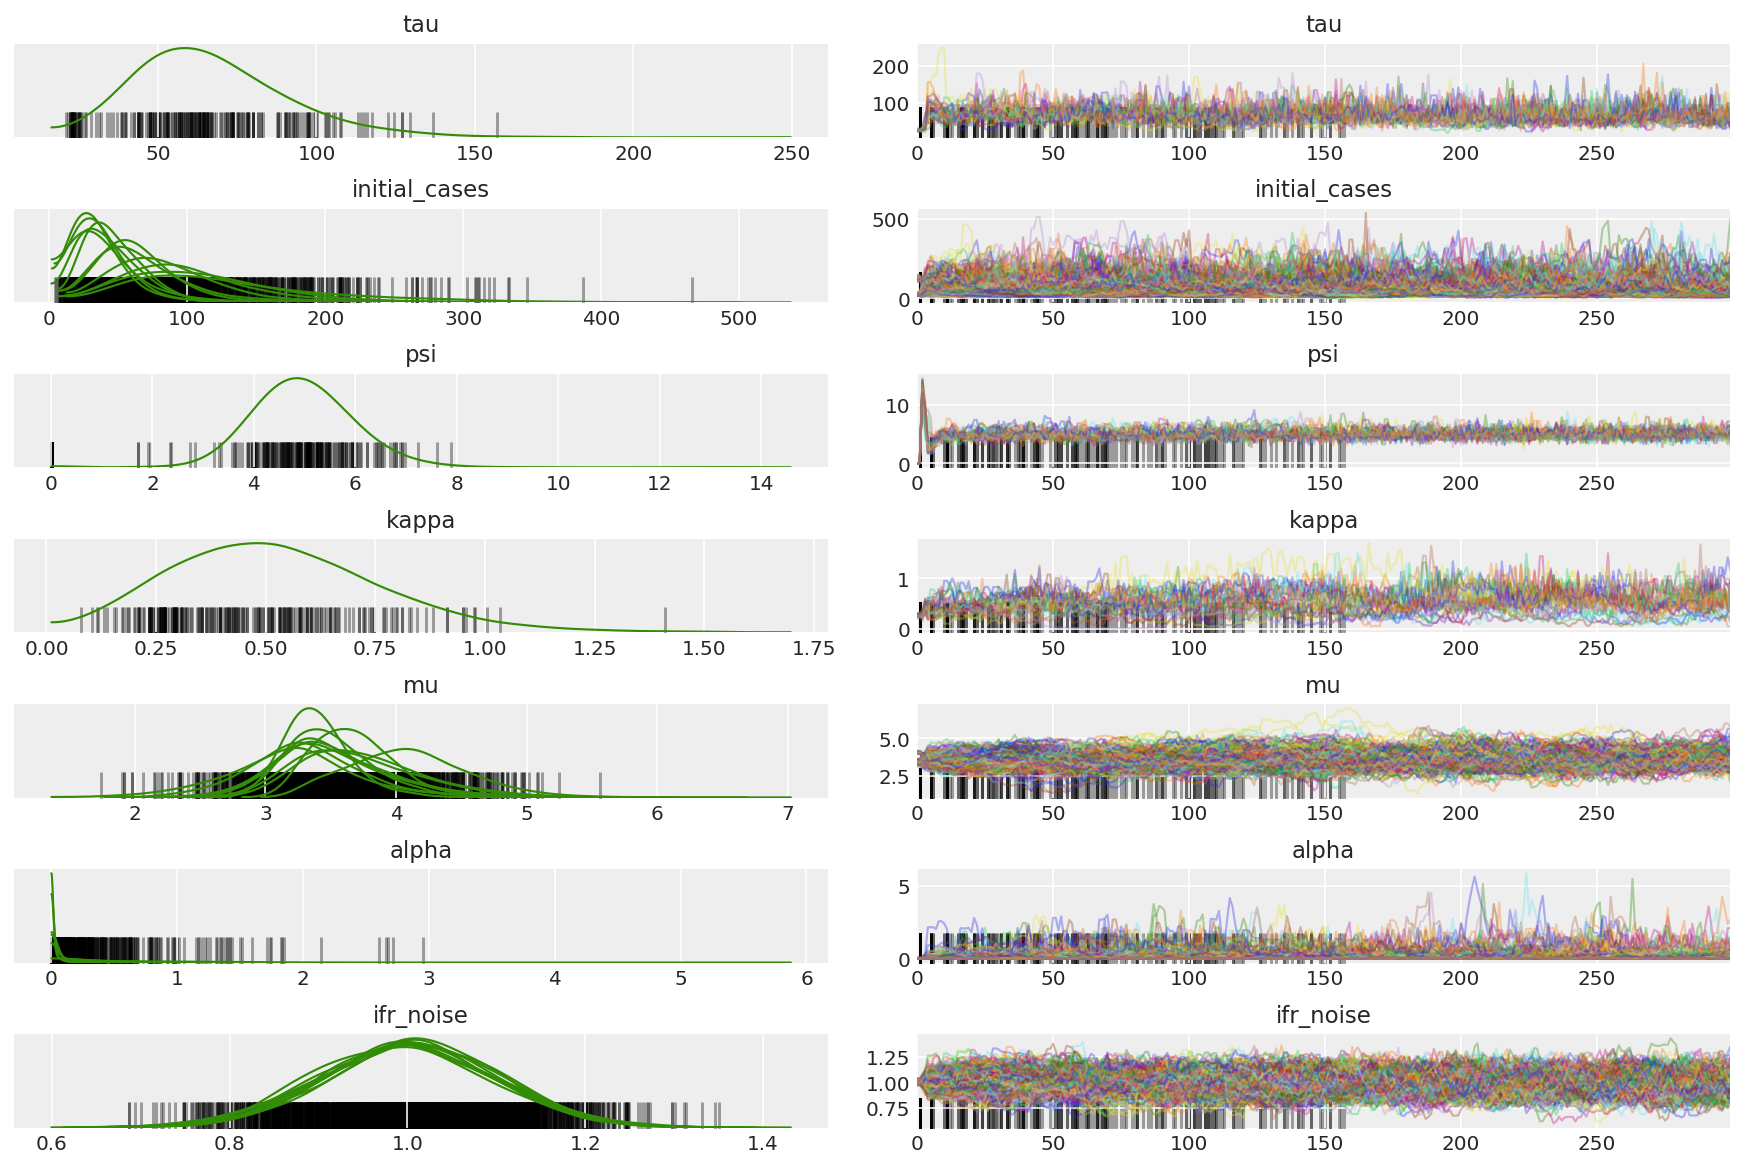

In [0]:
az_trace = az.from_dict(posterior=pilot_with_warmup,
                        sample_stats={'diverging': np.swapaxes(pilot_sampler_stat['diverging'].numpy(), 0, 1)})
az.plot_trace(az_trace, combined=True, compact=True, figsize=(12, 8));

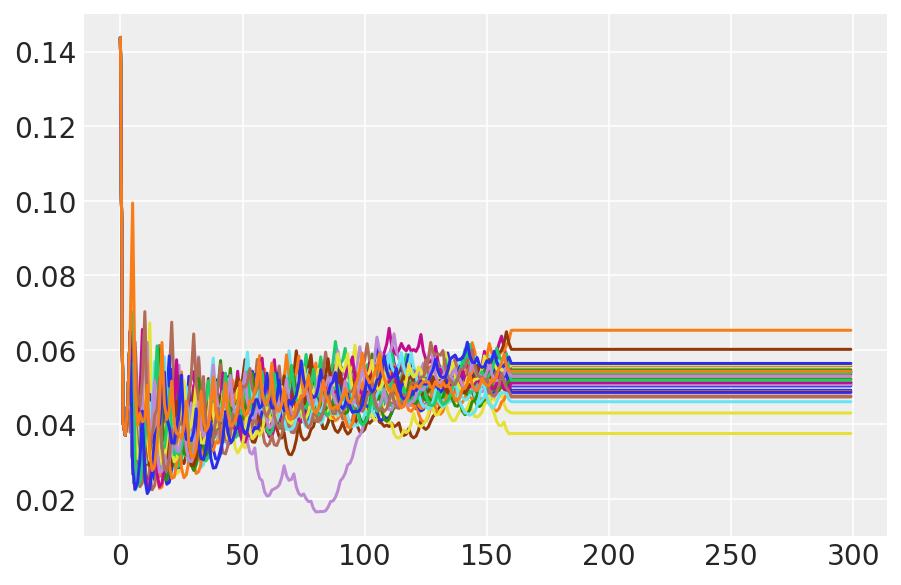

In [0]:
plt.plot(pilot_sampler_stat['step_size'][0]);

### 3.6  Run HMC

In principle we could use the pilot samples for final analysis (if we ran it for longer to get convergence), but it's a little more efficient to start another HMC run, this time preconditioned and initialized by pilot samples.

In [0]:
%%time

burnin = 50
num_steps = 200

bijectors = get_bijectors_from_samples([s[burnin:] for s in pilot_samples],
                                       unconstraining_bijectors=unconstraining_bijectors,
                                       batch_axes=(0, 1))

samples, sampler_stat = sample_hmc(
    [s[-1] for s in pilot_samples],
    [s[-1] for s in pilot_sampler_stat['step_size']],
    target_log_prob_fn,
    bijectors,
    num_steps=num_steps,
    burnin=burnin,
    num_leapfrog_steps=20)

CPU times: user 1min 26s, sys: 3.88 s, total: 1min 30s
Wall time: 1min 32s


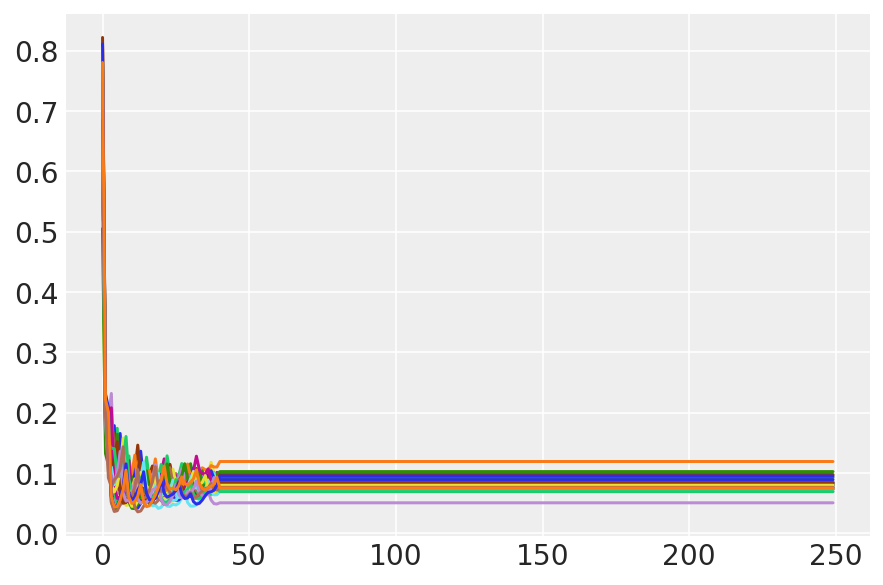

In [0]:
plt.plot(sampler_stat['step_size'][0]);

### 3.7  Visualize samples

In [0]:
import arviz as az
az.style.use('arviz-darkgrid')

In [0]:
var_name = ['tau', 'initial_cases', 'psi', 'kappa', 'mu', 'alpha', 'ifr_noise']

posterior = {k: np.swapaxes(v.numpy()[burnin:], 1, 0)
             for k, v in zip(var_name, samples)}
posterior_with_warmup = {k: np.swapaxes(v.numpy(), 1, 0)
             for k, v in zip(var_name, samples)}

Compute the summary of the chains. We're looking for high ESS and r_hat close to 1.

In [0]:
az.summary(posterior)

mean      sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  ess_bulk  ess_tail  r_hat
tau                 65.039  23.259  26.814  108.761      0.787    0.557     872.0   872.0     707.0     765.0   1.03
initial_cases[0]    99.807  50.092  15.689  189.582      1.370    0.969    1336.0  1336.0     809.0     683.0   1.03
initial_cases[1]   105.279  53.883  18.242  199.864      1.732    1.225     968.0   968.0     641.0    1132.0   1.04
initial_cases[2]    63.621  34.457  11.055  126.488      0.768    0.543    2013.0  2013.0    1573.0    1120.0   1.02
initial_cases[3]    44.506  21.851  11.258   85.150      0.741    0.524     868.0   868.0     770.0    1837.0   1.03
initial_cases[4]    42.208  24.220   5.624   84.947      0.760    0.538    1015.0  1015.0     668.0    1143.0   1.03
initial_cases[5]    60.160  26.771  15.874  107.703      0.922    0.652     844.0   844.0     662.0    1509.0   1.04
initial_cases[6]    41.959  29.708   5.255   93.510      0.599    0.439    2460.0  2285.0    2342.0    2818.0   1.01
initial_cases[7]   122.022  70.254  21.910  254.034      3.118    2.206     508.0   508.0     475.0    1479.0   1.05
initial_cases[8]    33.892  20.355   4.923   70.586      0.536    0.379    1443.0  1443.0     771.0    1581.0   1.03
initial_cases[9]    36.607  21.015   4.098   72.495      0.489    0.346    1843.0  1843.0    1119.0    2092.0   1.02
initial_cases[10]   81.963  38.106  19.723  150.441      1.147    0.811    1104.0  1104.0     694.0     726.0   1.03
psi                  5.064   0.892   3.488    6.787      0.017    0.012    2885.0  2814.0    3022.0    3699.0   1.01
kappa                0.568   0.265   0.080    1.048      0.015    0.011     293.0   293.0     303.0     506.0   1.07
mu[0]                3.567   0.564   2.594    4.645      0.027    0.020     434.0   384.0     611.0     660.0   1.04
mu[1]                3.761   0.532   2.899    4.769      0.028    0.021     354.0   327.0     454.0     550.0   1.05
mu[2]                3.389   0.510   2.490    4.445      0.016    0.012    1065.0   936.0    1336.0     990.0   1.02
mu[3]                3.725   0.334   3.106    4.318      0.013    0.009     675.0   669.0     698.0    1486.0   1.04
mu[4]                3.806   0.527   2.948    4.803      0.026    0.019     403.0   387.0     482.0     788.0   1.04
mu[5]                3.445   0.273   2.951    3.962      0.012    0.009     503.0   496.0     543.0    1176.0   1.04
mu[6]                3.218   0.554   2.135    4.284      0.013    0.009    1861.0  1761.0    2005.0    2123.0   1.02
mu[7]                4.172   0.477   3.287    5.020      0.023    0.016     419.0   419.0     413.0    1258.0   1.05
mu[8]                3.574   0.496   2.739    4.580      0.020    0.015     601.0   561.0     741.0    1046.0   1.03
mu[9]                3.541   0.461   2.792    4.479      0.019    0.014     580.0   551.0     712.0    1409.0   1.03
mu[10]               3.513   0.345   2.931    4.169      0.015    0.011     525.0   482.0     669.0     729.0   1.03
alpha[0]             0.175   0.235   0.000    0.636      0.010    0.007     525.0   525.0     781.0    1100.0   1.04
alpha[1]             0.015   0.035   0.000    0.073      0.001    0.000    4808.0  3687.0    4438.0    4320.0   1.01
alpha[2]             0.070   0.136   0.000    0.333      0.003    0.002    1737.0  1737.0    3199.0    2197.0   1.01
alpha[3]             0.610   0.673   0.000    1.784      0.020    0.014    1106.0  1106.0    1033.0    3618.0   1.02
alpha[4]             0.024   0.055   0.000    0.112      0.001    0.001    3352.0  3352.0    5587.0    3688.0   1.00
alpha[5]             0.016   0.040   0.000    0.073      0.001    0.001    1877.0  1372.0    3969.0    3416.0   1.01
ifr_noise[0]         1.004   0.099   0.820    1.185      0.001    0.001    5777.0  5777.0    5784.0    5314.0   1.00
ifr_noise[1]         1.005   0.100   0.820    1.193      0.001    0.001    4809.0  4809.0    4808.0    4862.0   1.00
ifr_noise[2]         1.000   0.100   0.813  

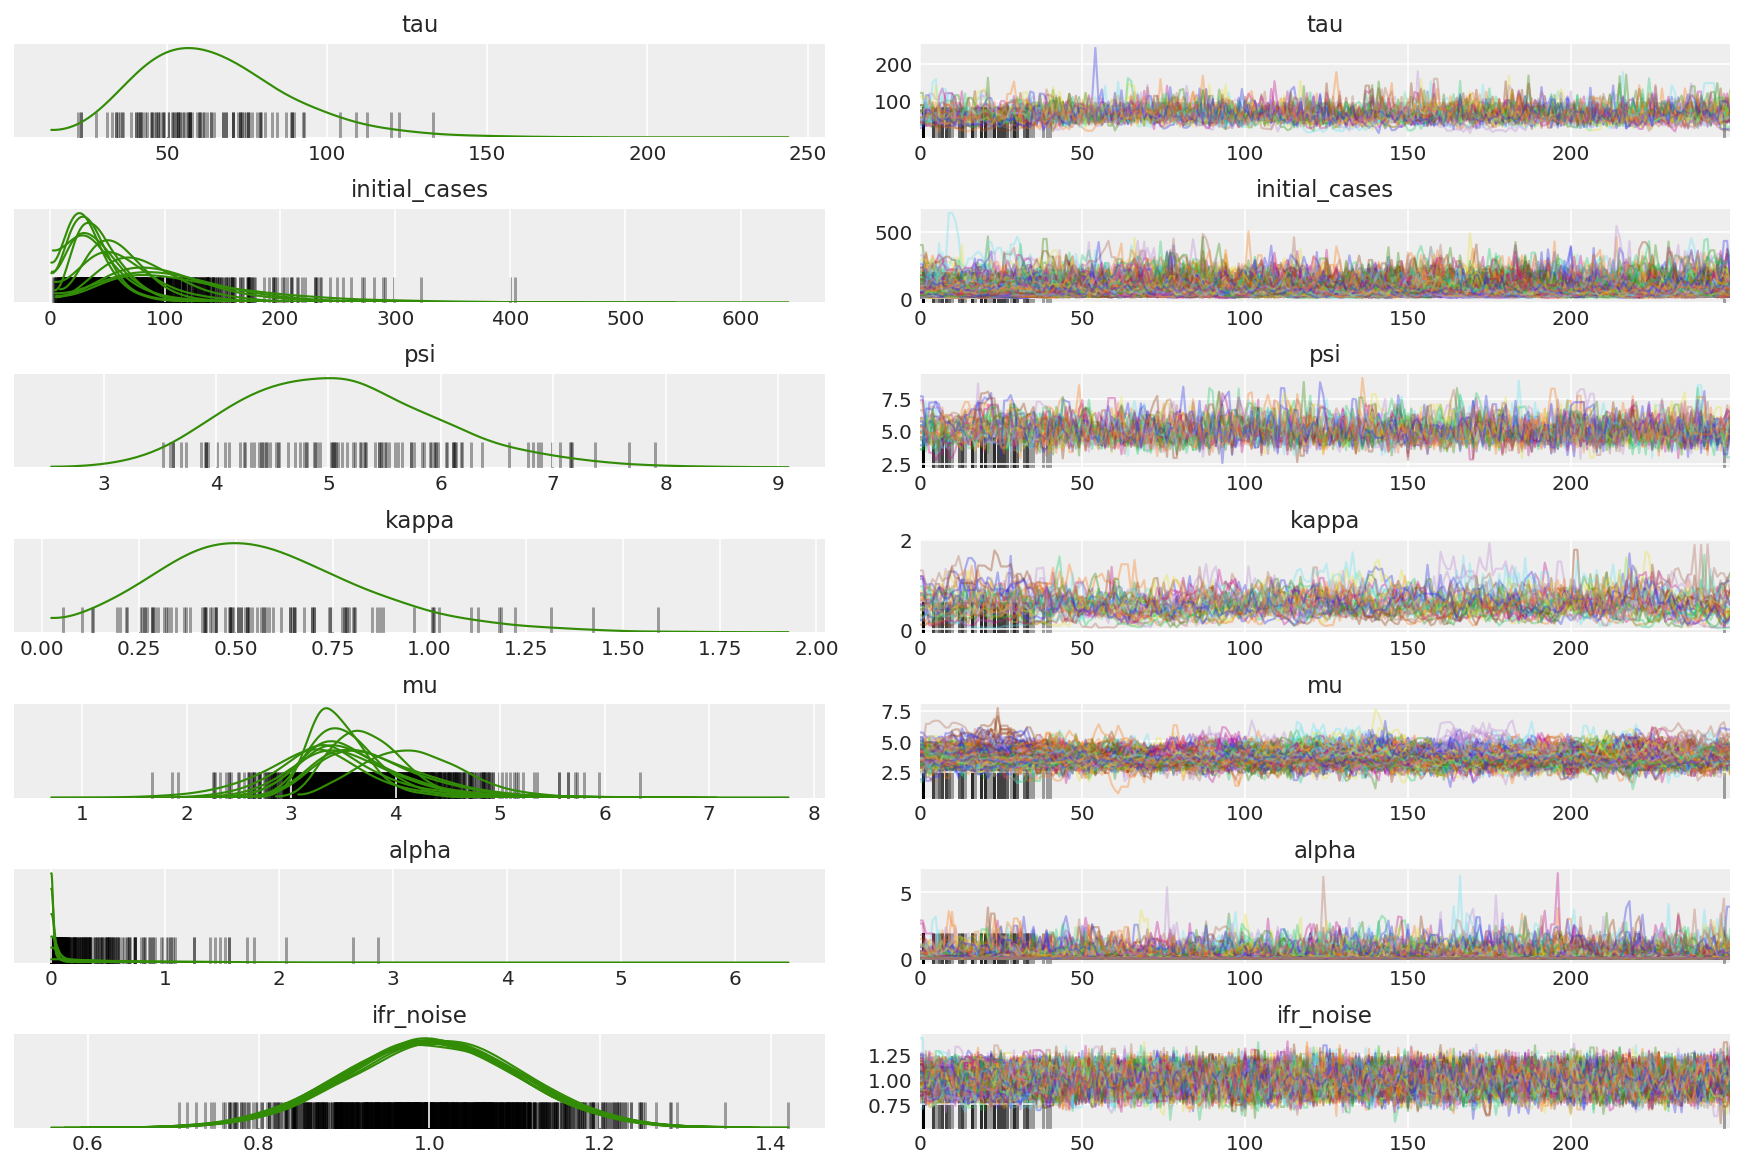

In [0]:
az_trace = az.from_dict(posterior=posterior_with_warmup,
                        sample_stats={'diverging': np.swapaxes(sampler_stat['diverging'].numpy(), 0, 1)})
az.plot_trace(az_trace, combined=True, compact=True, figsize=(12, 8));

It is instructive to look at the auto-correlation functions across all the dimensions. We're looking for functions which go down quickly, but not so much that they go into the negative (which is indicative of HMC hitting a resonance, which is bad for ergodicity and can introduce bias).

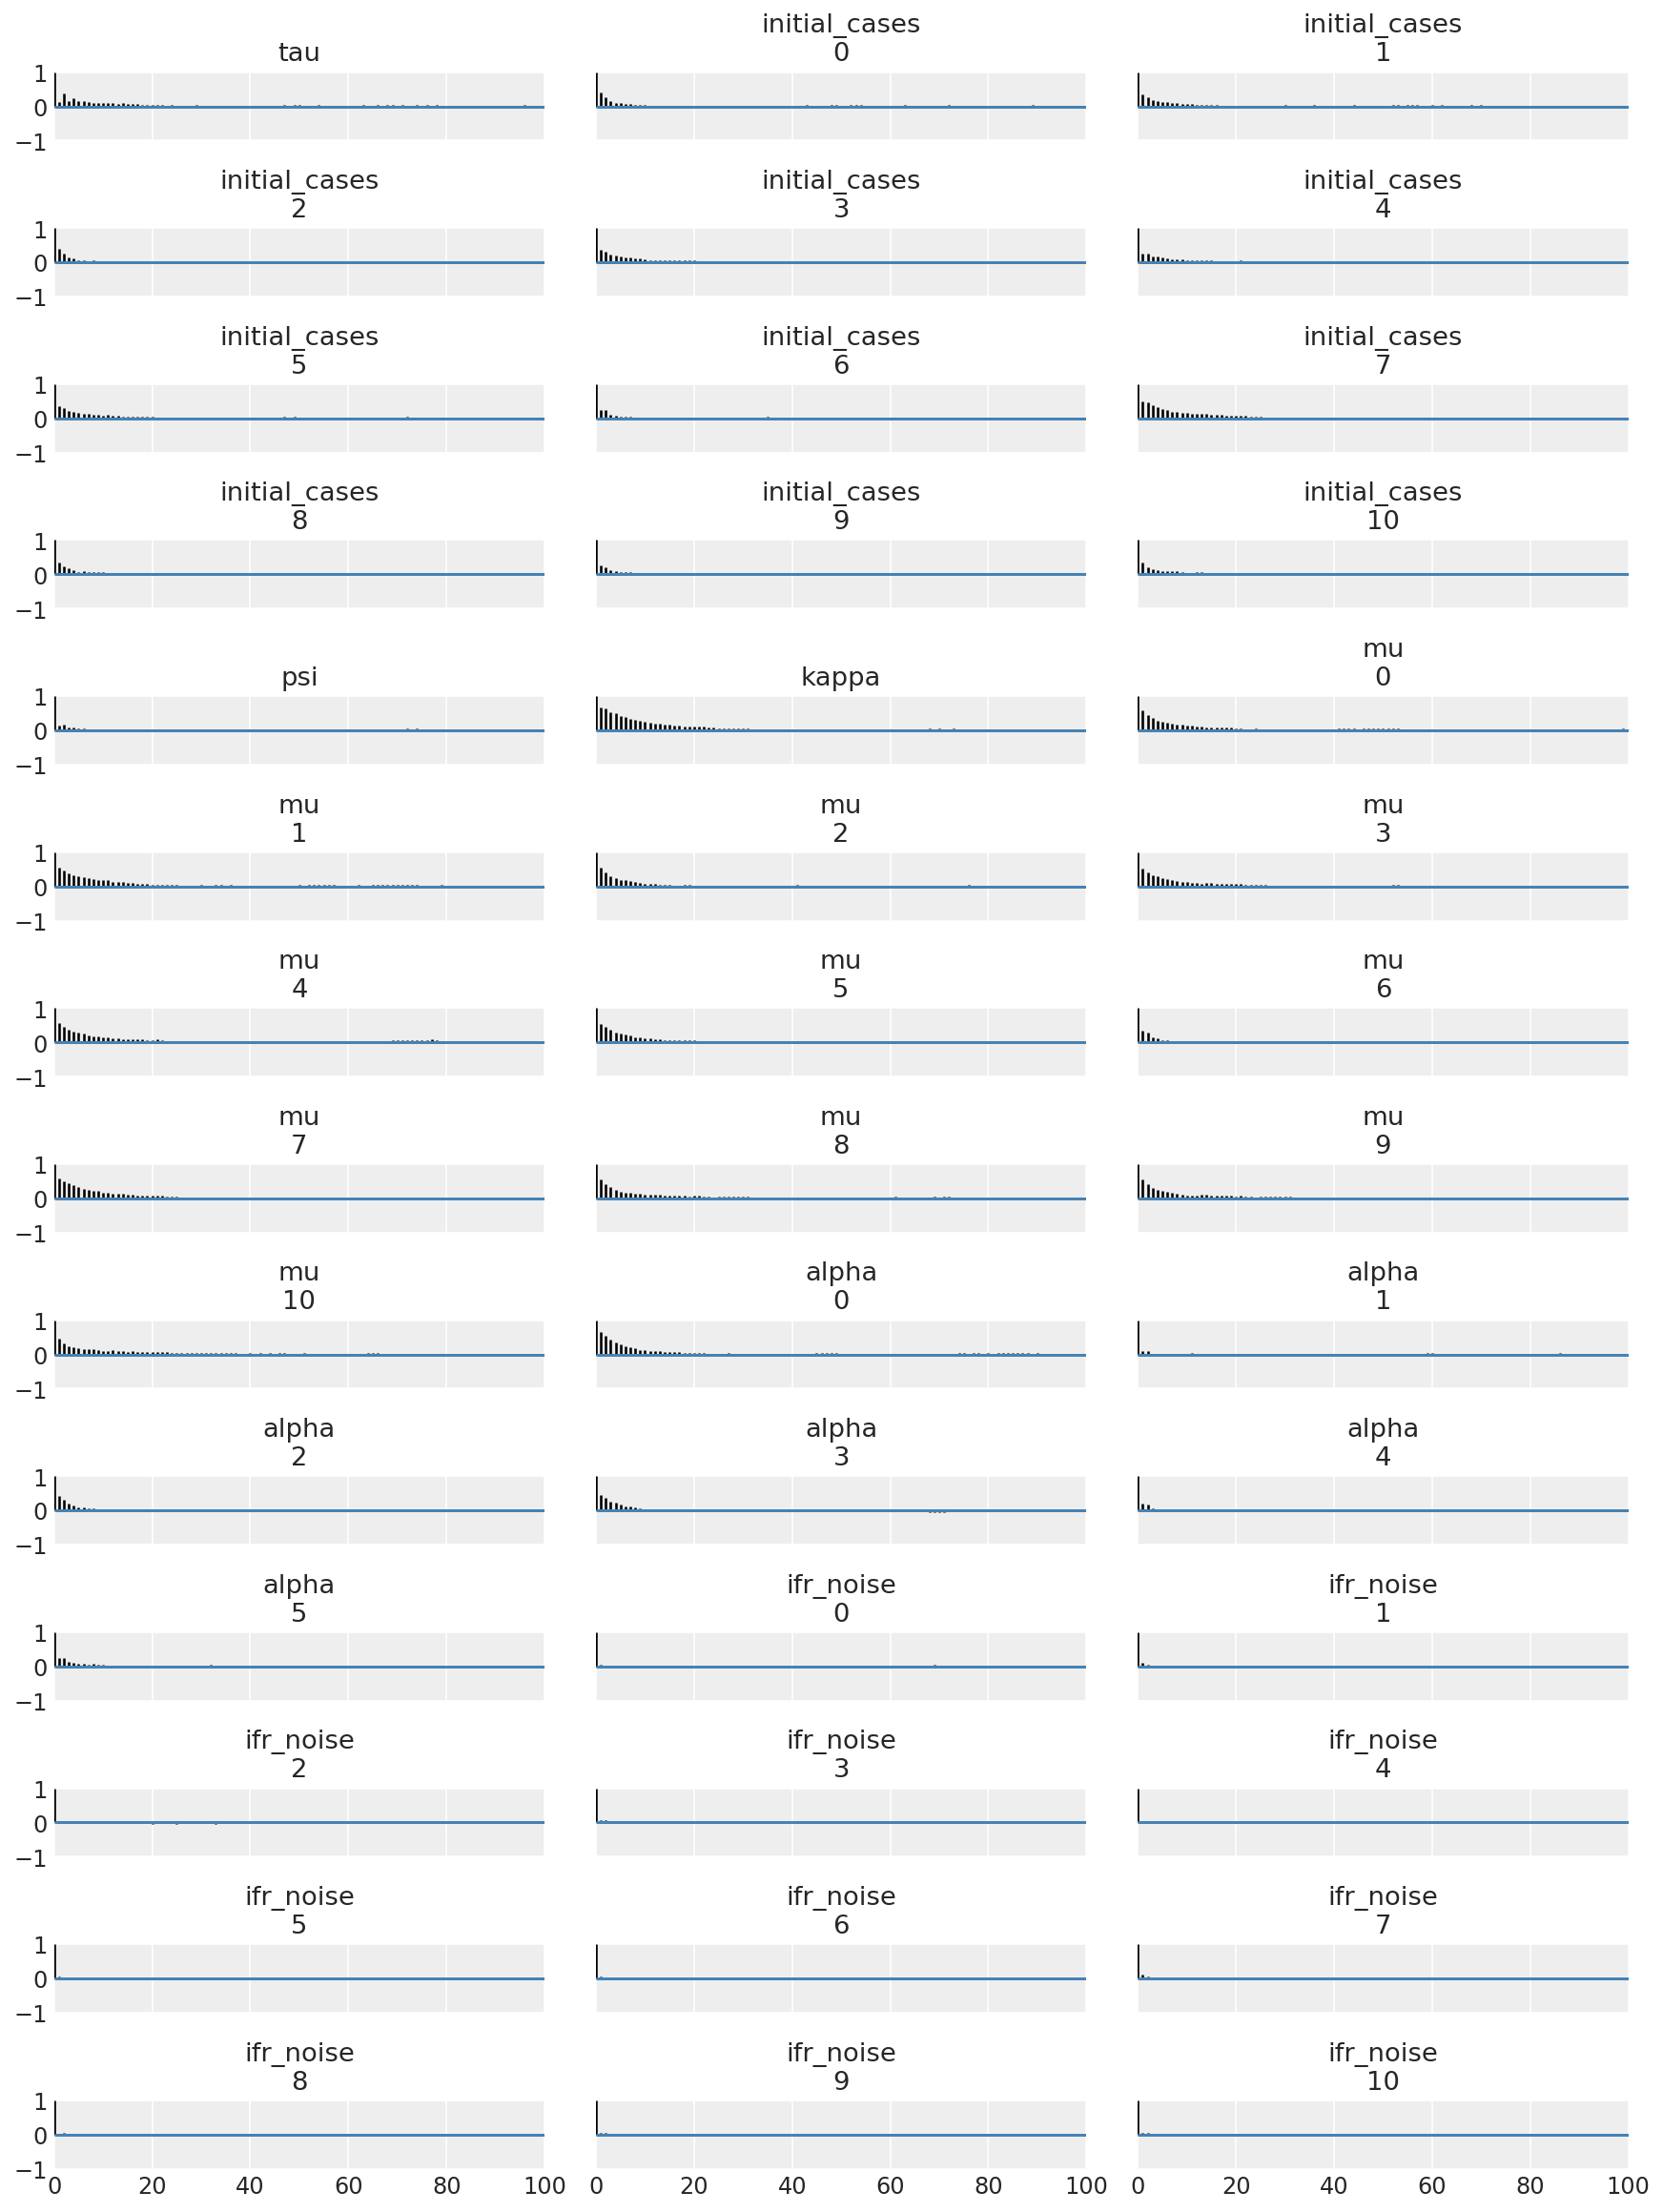

In [0]:
with az.rc_context(rc={'plot.max_subplots': None}):
  az.plot_autocorr(posterior, combined=True, figsize=(12, 16), textsize=12);

## 4  Results

The following plots analyze the posterior predictive distributions over $R_t$, number of deaths, and number of infections, similar to the analysis in Flaxman et al. (2020).

In [0]:
total_num_samples = np.prod(posterior['mu'].shape[:2])

# Calculate R_t given parameter estimates.
def rt_samples_batched(mu, intervention_indicators, alpha):
  linear_prediction = tf.reduce_sum(
      intervention_indicators * alpha[..., np.newaxis, np.newaxis, :], axis=-1)
  rt_hat = mu[..., tf.newaxis] * tf.exp(-linear_prediction, name='rt')
  return rt_hat

alpha_hat = tf.convert_to_tensor(
    posterior['alpha'].reshape(total_num_samples, posterior['alpha'].shape[-1]))
mu_hat = tf.convert_to_tensor(
    posterior['mu'].reshape(total_num_samples, num_countries))
rt_hat = rt_samples_batched(mu_hat, intervention_indicators, alpha_hat)
sampled_initial_cases = posterior['initial_cases'].reshape(
    total_num_samples, num_countries)
sampled_ifr_noise = posterior['ifr_noise'].reshape(
    total_num_samples, num_countries)
psi_hat = posterior['psi'].reshape([total_num_samples])

conv_serial_interval = make_conv_serial_interval(INITIAL_DAYS, TOTAL_DAYS)
conv_fatality_rate = make_conv_fatality_rate(infection_fatality_rate, TOTAL_DAYS)
pred_hat = predict_infections(
    intervention_indicators, population_value, sampled_initial_cases, mu_hat,
    alpha_hat, conv_serial_interval, INITIAL_DAYS, TOTAL_DAYS)
expected_deaths = predict_deaths(pred_hat, sampled_ifr_noise, conv_fatality_rate)

psi_m = psi_hat[np.newaxis, ..., np.newaxis]
probs = tf.clip_by_value(expected_deaths / (expected_deaths + psi_m), 1e-9, 1.)
predicted_deaths = tfd.NegativeBinomial(
    total_count=psi_m, probs=probs).sample()


In [0]:
# Predict counterfactual infections/deaths in the absence of interventions
no_intervention_infections = predict_infections(
    intervention_indicators,
    population_value,
    sampled_initial_cases,
    mu_hat,
    tf.zeros_like(alpha_hat),
    conv_serial_interval,
    INITIAL_DAYS, TOTAL_DAYS)

no_intervention_expected_deaths = predict_deaths(
    no_intervention_infections, sampled_ifr_noise, conv_fatality_rate)
probs = tf.clip_by_value(
    no_intervention_expected_deaths / (no_intervention_expected_deaths + psi_m),
    1e-9, 1.)
no_intervention_predicted_deaths = tfd.NegativeBinomial(
    total_count=psi_m, probs=probs).sample()

### 4.1  Effectiveness of interventions

Similar to Figure 4 of Flaxman et al. (2020).

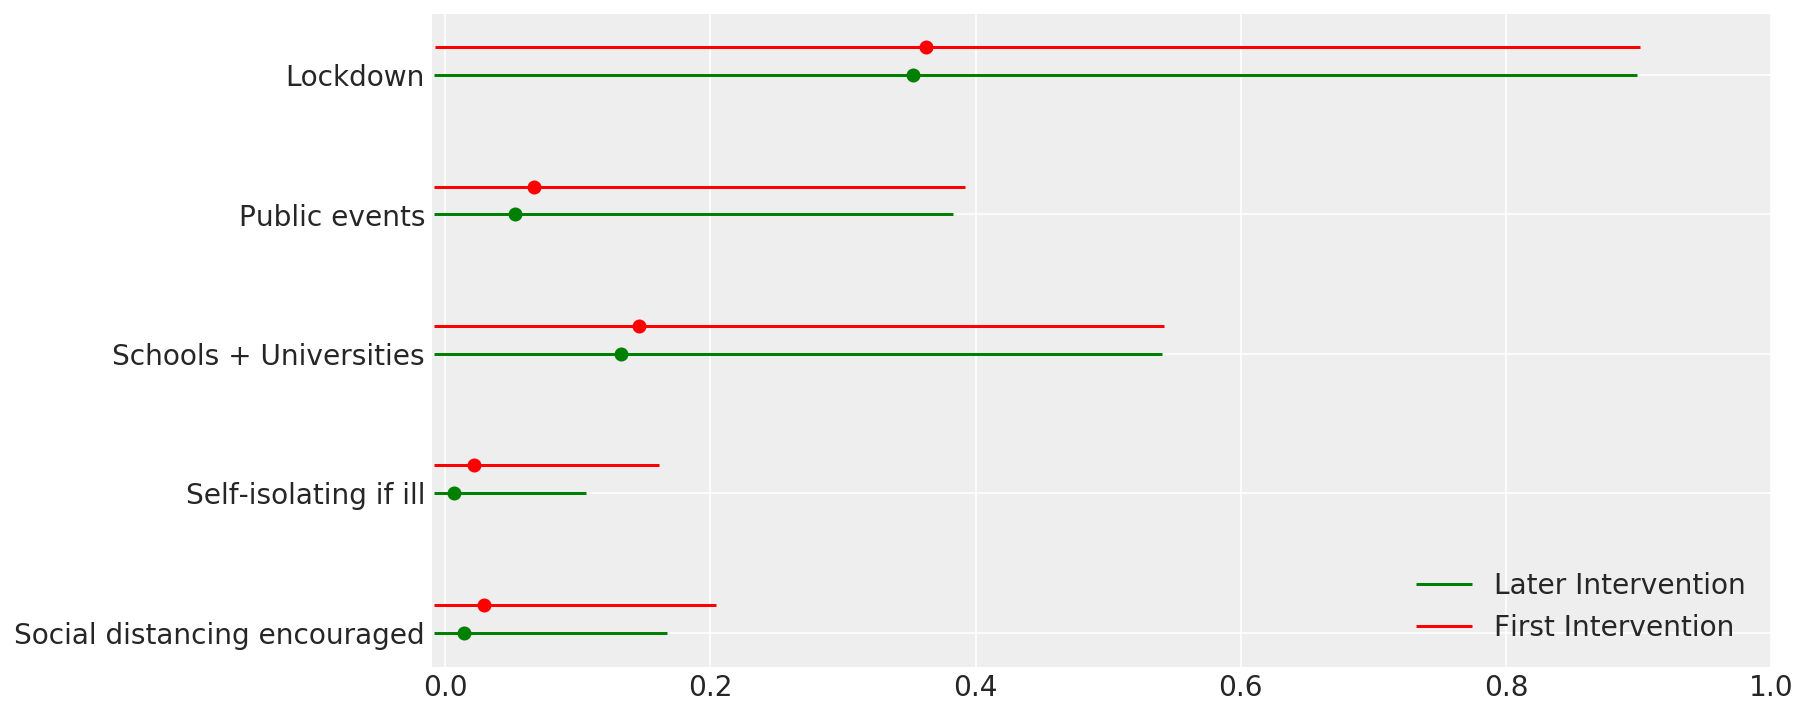

In [0]:
def intervention_effectiveness(alpha):

  alpha_adj = 1. - np.exp(-alpha + np.log(1.05) / 6.)
  alpha_adj_first = (
      1. - np.exp(-alpha - alpha[..., -1:] + np.log(1.05) / 6.))

  fig, ax = plt.subplots(1, 1, figsize=[12, 6])
  intervention_perm = [2, 1, 3, 4, 0]
  percentile_vals = [2.5, 97.5]
  jitter = .2

  for ind in range(5):
    first_low, first_high = tfp.stats.percentile(
        alpha_adj_first[..., ind], percentile_vals)
    low, high = tfp.stats.percentile(
        alpha_adj[..., ind], percentile_vals)

    p_ind = intervention_perm[ind]
    ax.hlines(p_ind, low, high, label='Later Intervention', colors='g')
    ax.scatter(alpha_adj[..., ind].mean(), p_ind, color='g')
    ax.hlines(p_ind + jitter, first_low, first_high,
              label='First Intervention', colors='r')
    ax.scatter(alpha_adj_first[..., ind].mean(), p_ind + jitter, color='r')

    if ind == 0:
      plt.legend(loc='lower right')
  ax.set_yticks(range(5))
  ax.set_yticklabels(
      [any_intervention_list[intervention_perm.index(p)] for p in range(5)])
  ax.set_xlim([-0.01, 1.])
  r = fig.patch
  r.set_facecolor('white') 

intervention_effectiveness(alpha_hat)

### 4.2  Infections, deaths, and R_t by country
Similar to Figure 2 of Flaxman et al. (2020).

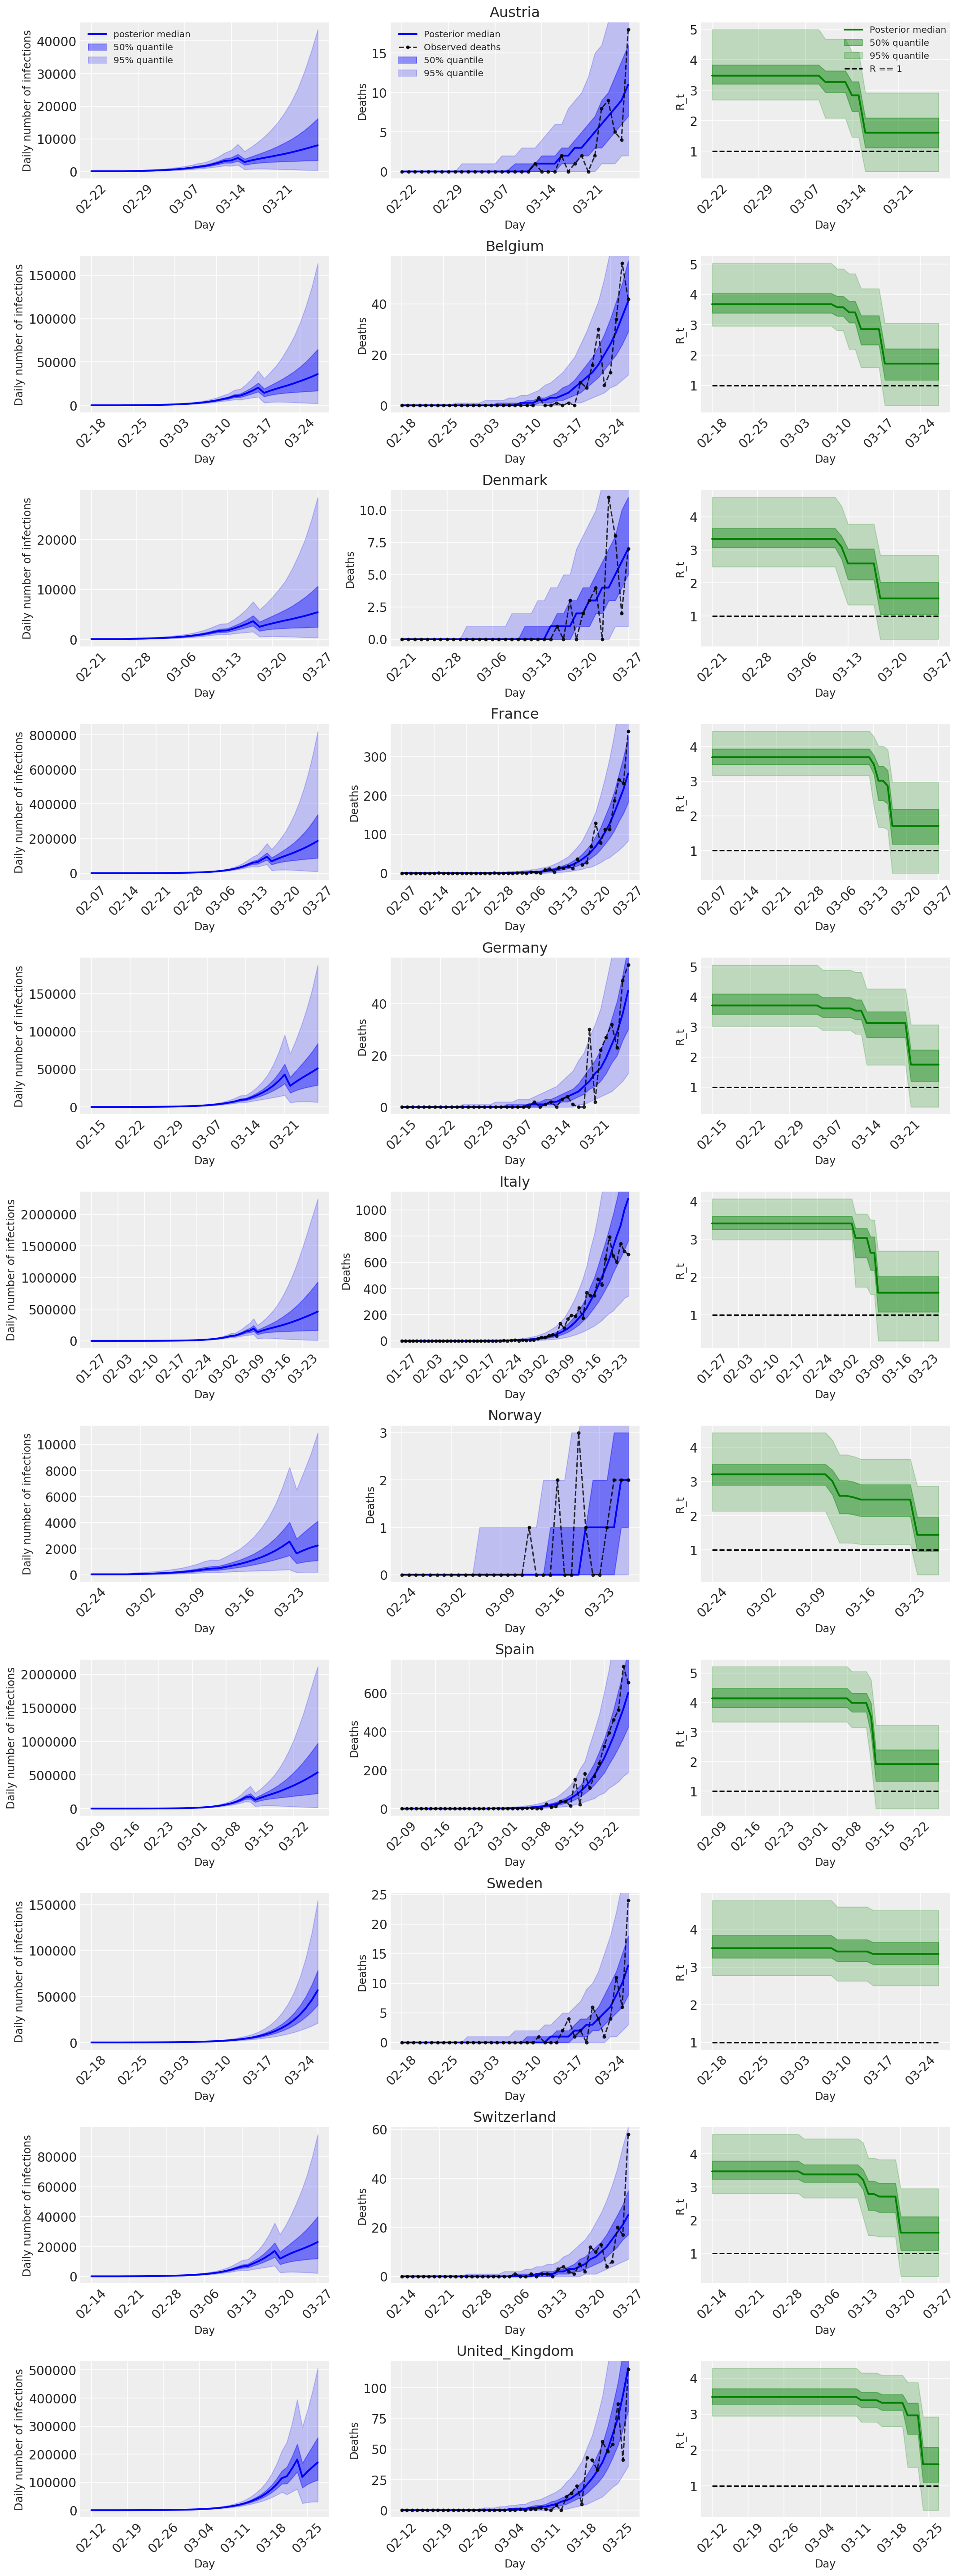

In [0]:
import matplotlib.dates as mdates

plot_quantile = True #@param {type:"boolean"}
forecast_days = 0 #@param {type:"slider", min:0, max:75, step:1}

fig, ax = plt.subplots(11, 3, figsize=(15, 40))

for ind, country in enumerate(COUNTRIES):
  num_days = (pd.to_datetime('2020-03-28') - first_days[country]).days + forecast_days
  dates = [(first_days[country] + i*pd.to_timedelta(1, 'days')).strftime('%m-%d') for i in range(num_days)]
  plot_dates = [dates[i] for i in range(0, num_days, 7)]

  # Plot daily number of infections
  infections = pred_hat[:, :, ind]
  posterior_quantile = np.percentile(infections, [2.5, 25, 50, 75, 97.5], axis=-1)
  ax[ind, 0].plot(
      dates, posterior_quantile[2, :num_days],
      color='b', label='posterior median', lw=2)
  if plot_quantile:
    ax[ind, 0].fill_between(
        dates, posterior_quantile[1, :num_days], posterior_quantile[3, :num_days],
        color='b', label='50% quantile', alpha=.4)
    ax[ind, 0].fill_between(
        dates, posterior_quantile[0, :num_days], posterior_quantile[4, :num_days],
        color='b', label='95% quantile', alpha=.2)

  ax[ind, 0].set_xticks(plot_dates)
  ax[ind, 0].xaxis.set_tick_params(rotation=45)
  ax[ind, 0].set_ylabel('Daily number of infections', fontsize='large')
  ax[ind, 0].set_xlabel('Day', fontsize='large')

  # Plot deaths
  ax[ind, 1].set_title(country)

  samples = predicted_deaths[:, :, ind]
  posterior_quantile = np.percentile(samples, [2.5, 25, 50, 75, 97.5], axis=-1)
  ax[ind, 1].plot(
      range(num_days), posterior_quantile[2, :num_days],
      color='b', label='Posterior median', lw=2)
  if plot_quantile:
    ax[ind, 1].fill_between(
        range(num_days), posterior_quantile[1, :num_days], posterior_quantile[3, :num_days],
        color='b', label='50% quantile', alpha=.4)
    ax[ind, 1].fill_between(
        range(num_days), posterior_quantile[0, :num_days], posterior_quantile[4, :num_days],
        color='b', label='95% quantile', alpha=.2)

  observed = deaths[ind, :]
  observed[observed == -1] = np.nan
  ax[ind, 1].plot(
      dates, observed[:num_days],
      '--o', color='k', markersize=3,
      label='Observed deaths', alpha=.8)
  ax[ind, 1].set_xticks(plot_dates)
  ax[ind, 1].xaxis.set_tick_params(rotation=45)
  ax[ind, 1].set_title(country)
  ax[ind, 1].set_xlabel('Day', fontsize='large')
  ax[ind, 1].set_ylabel('Deaths', fontsize='large')

  # Plot R_t
  samples = np.transpose(rt_hat[:, ind, :])
  posterior_quantile = np.percentile(samples, [2.5, 25, 50, 75, 97.5], axis=-1)
  l1 = ax[ind, 2].plot(
      dates, posterior_quantile[2, :num_days],
      color='g', label='Posterior median', lw=2)
  l2 = ax[ind, 2].fill_between(
      dates, posterior_quantile[1, :num_days], posterior_quantile[3, :num_days],
      color='g', label='50% quantile', alpha=.4)
  if plot_quantile:
    l3 = ax[ind, 2].fill_between(
        dates, posterior_quantile[0, :num_days], posterior_quantile[4, :num_days],
        color='g', label='95% quantile', alpha=.2)

  l4 = ax[ind, 2].hlines(1., dates[0], dates[-1], linestyle='--', label='R == 1')
  ax[ind, 2].set_xlabel('Day', fontsize='large')
  ax[ind, 2].set_ylabel('R_t', fontsize='large')
  ax[ind, 2].set_xticks(plot_dates)
  ax[ind, 2].xaxis.set_tick_params(rotation=45)

fontsize = 'medium'
ax[0, 0].legend(loc='upper left', fontsize=fontsize)
ax[0, 1].legend(loc='upper left', fontsize=fontsize)
ax[0, 2].legend(
  bbox_to_anchor=(1., 1.),
  loc='upper right',
  borderaxespad=0.,
  fontsize=fontsize)

plt.tight_layout();

### 4.3  Daily number of predicted/forecasted deaths with and without interventions

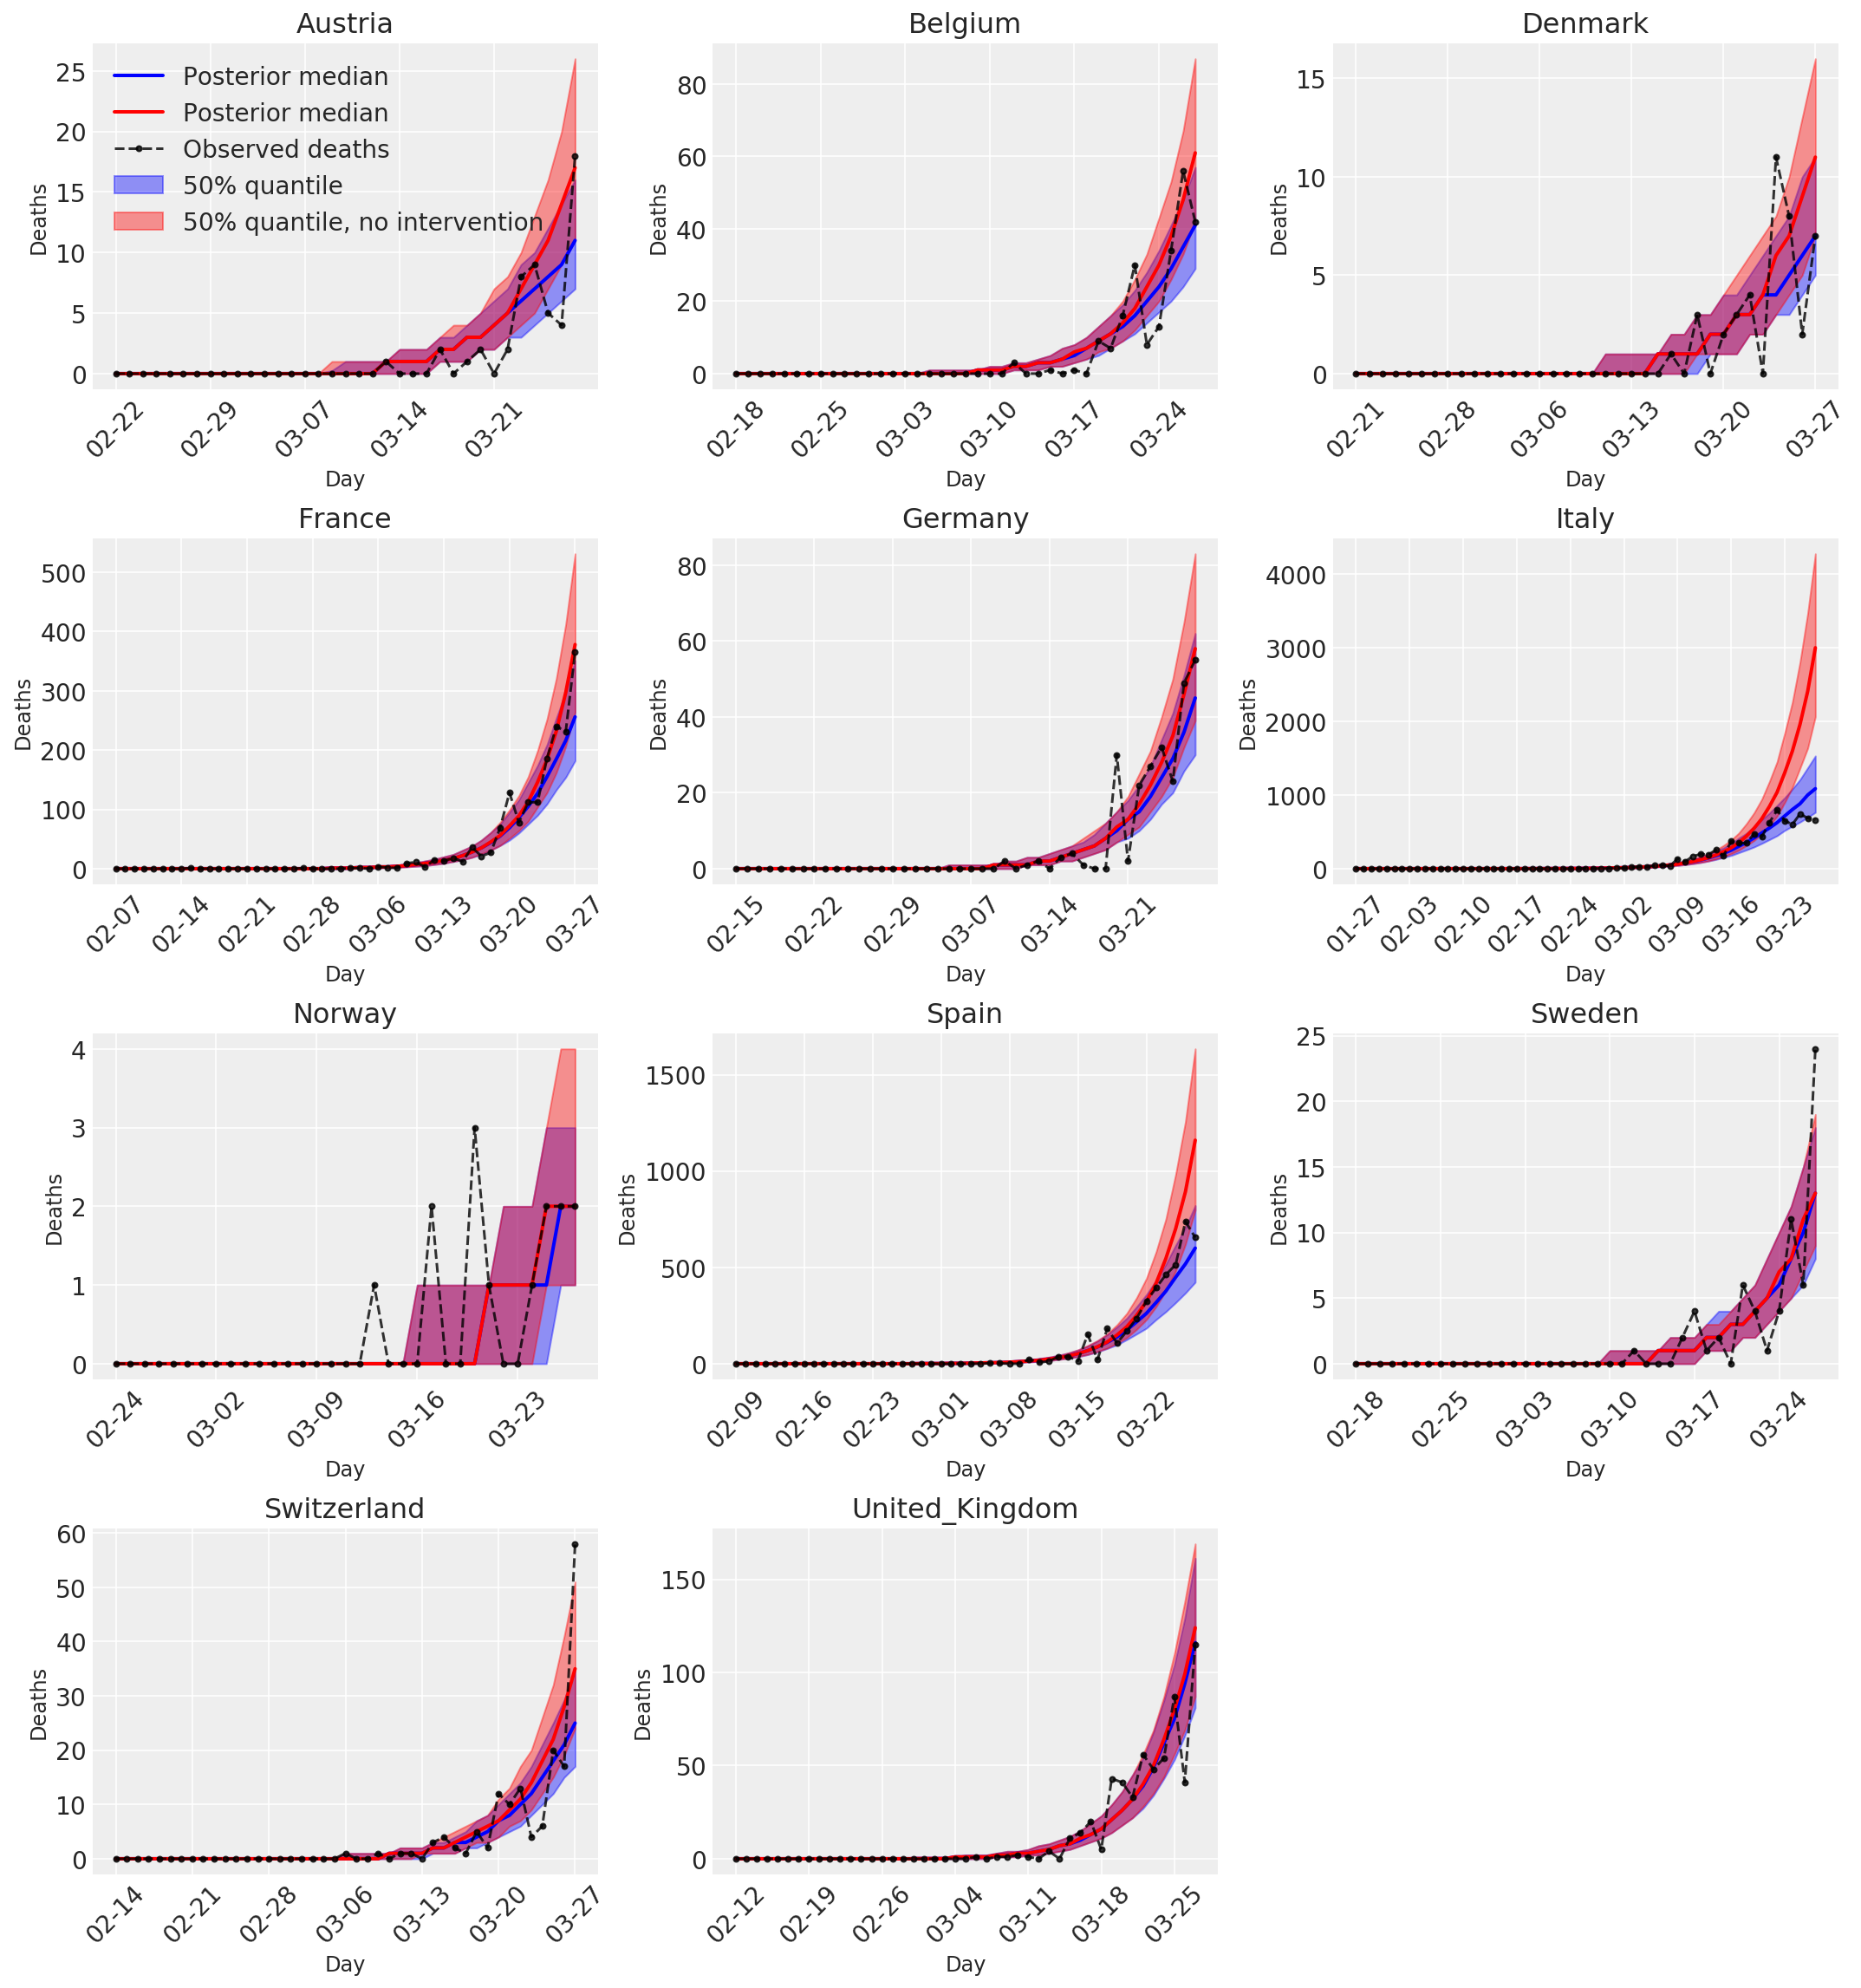

In [0]:
plot_quantile = True #@param {type:"boolean"}
forecast_days = 0 #@param {type:"slider", min:0, max:30, step:1}

fig, ax = plt.subplots(4, 3, figsize=(15, 16))
ax = ax.flatten()
fig.delaxes(ax[-1])
for country_index, country in enumerate(COUNTRIES):
  num_days = (pd.to_datetime('2020-03-28') - first_days[country]).days + forecast_days
  dates = [(first_days[country] + i*pd.to_timedelta(1, 'days')).strftime('%m-%d') for i in range(num_days)]
  plot_dates = [dates[i] for i in range(0, num_days, 7)]

  ax[country_index].set_title(country)

  quantile_vals = [.025, .25, .5, .75, .975]
  samples = predicted_deaths[:, :, country_index].numpy()
  quantiles = []

  psi_m = psi_hat[np.newaxis, ..., np.newaxis]
  probs = tf.clip_by_value(expected_deaths / (expected_deaths + psi_m), 1e-9, 1.)
  predicted_deaths_dist = tfd.NegativeBinomial(
    total_count=psi_m, probs=probs)

  posterior_quantile = np.percentile(samples, [2.5, 25, 50, 75, 97.5], axis=-1)
  ax[country_index].plot(
      dates, posterior_quantile[2, :num_days],
      color='b', label='Posterior median', lw=2)
  if plot_quantile:
    ax[country_index].fill_between(
        dates, posterior_quantile[1, :num_days], posterior_quantile[3, :num_days],
        color='b', label='50% quantile', alpha=.4)

  samples_counterfact = no_intervention_predicted_deaths[:, :, country_index]
  posterior_quantile = np.percentile(samples_counterfact, [2.5, 25, 50, 75, 97.5], axis=-1)
  ax[country_index].plot(
      dates, posterior_quantile[2, :num_days],
      color='r', label='Posterior median', lw=2)
  if plot_quantile:
    ax[country_index].fill_between(
        dates, posterior_quantile[1, :num_days], posterior_quantile[3, :num_days],
        color='r', label='50% quantile, no intervention', alpha=.4)

  observed = deaths[country_index, :]
  observed[observed == -1] = np.nan
  ax[country_index].plot(
      dates, observed[:num_days],
      '--o', color='k', markersize=3,
      label='Observed deaths', alpha=.8)
  ax[country_index].set_xticks(plot_dates)
  ax[country_index].xaxis.set_tick_params(rotation=45)
  ax[country_index].set_title(country)
  ax[country_index].set_xlabel('Day', fontsize='large')
  ax[country_index].set_ylabel('Deaths', fontsize='large')
  ax[0].legend(loc='upper left')
plt.tight_layout(pad=1.0);